<a href="https://colab.research.google.com/github/GuiSSMartins/DTx-Project/blob/Faustino_Testes/DTx_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from graphviz import Digraph # para representação gráfica de grafos direcionados (utiliza linguagem dot)
import matplotlib.image as mpimg # operações relacionadas a imagens
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc #importing garbage collector
import time

In [3]:
# df_prices = pd.read_csv('sell_prices.csv')

# função para reduzir a dimensão de um dataset
def reduce_mem_usage(df, verbose=True):
    numerics = ['int8','int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

# diminuir o tamanho dos datasets
#df_prices = reduce_mem_usage(df_prices)

In [4]:
# Represenção do digrafo, aplicando cores e percentagens nas arrestas
dot = Digraph(comment='Grafo para descrever a Estrutura do Dados')

dot.node('A', f'Total de estados', color='lightblue2', style='filled')
dot.node('B', f'Estado CA', color='lightblue2', style='filled')
dot.node('C', f'Estado TX', color='lightblue2', style='filled')
dot.node('D', f'Estado W', color='lightblue2', style='filled')
dot.node('E', f'LOJA 1', color='lightblue2', style='filled')
dot.node('F', f'LOJA 2', color='lightblue2', style='filled')
dot.node('G', f'LOJA 3', color='lightblue2', style='filled')
dot.node('H', f'LOJA 4', color='lightblue2', style='filled')
dot.node('I', f'LOJA 1', color='lightblue2', style='filled')
dot.node('J', f'LOJA 2', color='lightblue2', style='filled')
dot.node('K', f'LOJA 3', color='lightblue2', style='filled')
dot.node('L', f'LOJA 1', color='lightblue2', style='filled')
dot.node('M', f'LOJA 2', color='lightblue2', style='filled')
dot.node('N', f'LOJA 3', color='lightblue2', style='filled')
dot.node('JA', f'CATEGORY HOBBIES', color='lightblue2', style='filled')
dot.node('JB', f'CATEGORY FOOD', color='lightblue2', style='filled')
dot.node('JC', f'CATEGORY HOUSEHOLD', color='lightblue2', style='filled')
dot.node('JAA', f'DEPARTAMENT HOBBIES 1', color='lightblue2', style='filled')
dot.node('JAB', f'DEPARTAMENT HOBBIES 2', color='lightblue2', style='filled')
dot.node('JBA', f'DEPARTAMENT FOOD 1', color='lightblue2', style='filled')
dot.node('JBB', f'DEPARTAMENT FOOD 2', color='lightblue2', style='filled')
dot.node('JBC', f'DEPARTAMENT FOOD 3', color='lightblue2', style='filled')
dot.node('JCA', f'DEPARTAMENT HOUSEHOLD 1', color='lightblue2', style='filled')
dot.node('JCB', f'DEPARTAMENT HOUSEHOLD 2', color='lightblue2', style='filled')


dot.edge('A', 'B')
dot.edge('A', 'C')
dot.edge('A', 'D')
dot.edge('B', 'E')
dot.edge('B', 'F')
dot.edge('B', 'G')
dot.edge('B', 'H')
dot.edge('C', 'I')
dot.edge('C', 'J')
dot.edge('C', 'K')
dot.edge('D', 'L')
dot.edge('D', 'M')
dot.edge('D', 'N')
dot.edge('J', 'JA')
dot.edge('J', 'JB')
dot.edge('J', 'JC')
dot.edge('JA', 'JAA')
dot.edge('JA', 'JAB')
dot.edge('JB', 'JBA')
dot.edge('JB', 'JBB')
dot.edge('JB', 'JBC')
dot.edge('JC', 'JCA')
dot.edge('JC', 'JCB')

dot.render('/content/drive/MyDrive/Save/patient_dot', format='png', cleanup=True)

'/content/drive/MyDrive/Save/patient_dot.png'

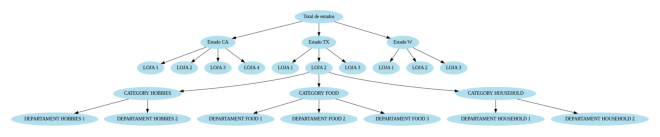

In [5]:
image = mpimg.imread('/content/drive/MyDrive/Save/patient_dot.png')

fig, ax = plt.subplots() #criar uma subparcela única
ax.imshow(image) #exibir a imagem na subparcela e desativar os eixos
ax.axis('off')
#centralizar a imagem na subparcela
ax.set_position([0, 0, 1, 1])  # Define a posição da subparcela para cobrir toda a figura
#fig.savefig("/content/drive/MyDrive/Save/patient_dot.png")
plt.show() #pode nem ser colocado

### A análise exploratória dos dados e as suas coneções passam a ser feitas no KNIME!!!!!!

## Decomposição da Série Temporal

In [6]:
df_loja1_serie_temporal_agregada = pd.read_csv('loja1.csv')

df_loja1_serie_temporal_agregada = reduce_mem_usage(df_loja1_serie_temporal_agregada)


n_periods = 1913

# eliminar as colunas indesejadas para a construção da série temporal
df_time_series = pd.DataFrame(data={"Vendas": df_loja1_serie_temporal_agregada['Vendas_do_dia'].tolist()}, index=df_loja1_serie_temporal_agregada['date'])

Mem. usage decreased to  0.05 Mb (63.8% reduction)


In [7]:
df_loja1_serie_temporal_agregada

,date,wm_yr_wk,wday,month,year,d,Vendas_do_dia,n_eventos,week_group
0,2011-01-29,11101,1,1,2011,d_1,4337,0,0
1,2011-01-30,11101,2,1,2011,d_2,4155,0,0
2,2011-01-31,11101,3,1,2011,d_3,2816,0,1
3,2011-02-01,11101,4,2,2011,d_4,3051,0,1
4,2011-02-02,11101,5,2,2011,d_5,2630,0,1
...,...,...,...,...,...,...,...,...,...
1908,2016-04-20,11612,5,4,2016,d_1909,3722,0,1
1909,2016-04-21,11612,6,4,2016,d_1910,3709,0,1
1910,2016-04-22,11612,7,4,2016,d_1911,4387,0,1
1911,2016-04-23,11613,1,4,2016,d_1912,5577,0,0


In [8]:
print(df_loja1_serie_temporal_agregada.columns)

Index(['date', 'wm_yr_wk', 'wday', 'month', 'year', 'd', 'Vendas_do_dia',
       'n_eventos', 'week_group'],
      dtype='object')


In [9]:
print(df_time_series)

            Vendas
date              
2011-01-29    4337
2011-01-30    4155
2011-01-31    2816
2011-02-01    3051
2011-02-02    2630
...            ...
2016-04-20    3722
2016-04-21    3709
2016-04-22    4387
2016-04-23    5577
2016-04-24    6113

[1913 rows x 1 columns]


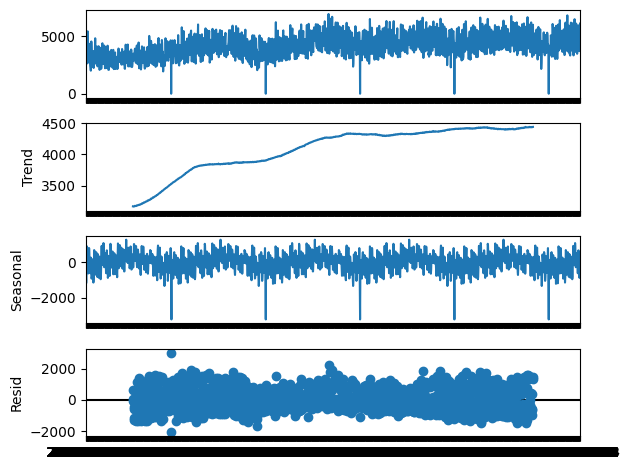

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(df_time_series, model='additive', period=365)
decomposition.plot()
plt.show()

## Carregar dados (agora concatenados)

In [11]:
df_loja1_RNN = reduce_mem_usage(df_loja1_serie_temporal_agregada)

#reduce_mem_usage(df_loja1_serie_temporal_agregada)

Mem. usage decreased to  0.05 Mb (0.0% reduction)


# Treino de Modelos

##### Rede Neuronal Recurrente (RNN)

In [12]:
'''import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Assuming df_loja1_RNN is your DataFrame
# You should load or define your DataFrame here

num_samples = 1913  # Assuming this is the correct number of samples
time_steps = 30
input_features = 3
output_features = 1

# Select specific input and output columns
# Assuming df_loja1_RNN is your DataFrame
selected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8]]  # Access columns using .iloc method
selected_output_column = df_loja1_RNN.iloc[:, 6]  # Access single column directly

# Convert DataFrame columns to NumPy arrays
X = selected_input_columns.values
Y = selected_output_column.values

# Calculate the number of sequences based on available samples and desired time steps
num_sequences = num_samples // time_steps

# Truncate the input and output data to fit the number of sequences#
X_truncated = X[:num_sequences * time_steps].reshape(num_sequences, time_steps, input_features)
Y_truncated = Y[(time_steps + 1):(num_sequences * time_steps + 1)].reshape(num_sequences, time_steps, output_features)
'''

'import pandas as pd\nimport numpy as np\nimport tensorflow as tf\nfrom tensorflow.keras.models import Sequential\nfrom tensorflow.keras.layers import Dense, SimpleRNN\n\n# Assuming df_loja1_RNN is your DataFrame\n# You should load or define your DataFrame here\n\nnum_samples = 1913  # Assuming this is the correct number of samples\ntime_steps = 30\ninput_features = 3\noutput_features = 1\n\n# Select specific input and output columns\n# Assuming df_loja1_RNN is your DataFrame\nselected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8]]  # Access columns using .iloc method\nselected_output_column = df_loja1_RNN.iloc[:, 6]  # Access single column directly\n\n# Convert DataFrame columns to NumPy arrays\nX = selected_input_columns.values\nY = selected_output_column.values\n\n# Calculate the number of sequences based on available samples and desired time steps\nnum_sequences = num_samples // time_steps\n\n# Truncate the input and output data to fit the number of sequences#\nX_truncated = X[

In [13]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN

# Select specific input and output columns
# Assuming df_loja1_RNN is your DataFrame
selected_input_columns = df_loja1_RNN.iloc[:, [1, 2, 7, 8, 6]]  # Access columns using .iloc method
selected_output_column = df_loja1_RNN.iloc[:, 6]  # Access single column directly

# Assuming you're using TensorFlow's timeseries_dataset_from_array
from tensorflow.keras.preprocessing import timeseries_dataset_from_array

input_data = selected_input_columns[:-7]
targets = selected_output_column[7:]
dataset = timeseries_dataset_from_array(
    input_data, targets, sequence_length=7)
for batch in dataset:
    inputs, targets = batch
    assert np.array_equal(inputs[0], selected_input_columns.values[:7])  # First sequence: steps [0-9]
    # Corresponding target: step 10
    assert np.array_equal(targets[0], selected_output_column.values[7])
    break

In [14]:
len(dataset)

15

In [15]:
inputs, targets = batch

inputs

<tf.Tensor: shape=(128, 7, 5), dtype=int16, numpy=
array([[[11101,     1,     0,     0,  4337],
        [11101,     2,     0,     0,  4155],
        [11101,     3,     0,     1,  2816],
        ...,
        [11101,     5,     0,     1,  2630],
        [11101,     6,     0,     1,  3276],
        [11101,     7,     0,     1,  3450]],

       [[11101,     2,     0,     0,  4155],
        [11101,     3,     0,     1,  2816],
        [11101,     4,     0,     1,  3051],
        ...,
        [11101,     6,     0,     1,  3276],
        [11101,     7,     0,     1,  3450],
        [11102,     1,     0,     0,  5437]],

       [[11101,     3,     0,     1,  2816],
        [11101,     4,     0,     1,  3051],
        [11101,     5,     0,     1,  2630],
        ...,
        [11101,     7,     0,     1,  3450],
        [11102,     1,     0,     0,  5437],
        [11102,     2,     1,     0,  4340]],

       ...,

       [[11118,     7,     0,     1,  3200],
        [11119,     1,     0,     0,

In [16]:
targets

<tf.Tensor: shape=(128,), dtype=int16, numpy=
array([5437, 4340, 3157, 2995, 2710, 2928, 3078, 4316, 4354, 2757, 2430,
       2272, 2009, 3015, 4553, 3966, 3264, 2441, 2377, 2414, 2701, 3719,
       3548, 2246, 2549, 2559, 2568, 2978, 4096, 4832, 3138, 2997, 2772,
       2650, 3249, 4114, 4094, 2880, 2384, 2522, 2435, 2744, 4142, 3904,
       2635, 2458, 2079, 2281, 2740, 3899, 3999, 2780, 2167, 2247, 2576,
       3500, 4325, 4396, 3642, 2784, 2602, 2976, 3294, 4083, 4194, 3015,
       2512, 2217, 2520, 2867, 3571, 4084, 2760, 2234, 2261, 2487, 3155,
       4187, 2946, 2439, 2085, 2096, 2086, 2675, 3560, 3668, 2911, 2839,
       2610, 2384, 3125, 3816, 3033, 3069, 2985, 2629, 2277, 3008, 3754,
       3822, 2582, 2144, 2174, 2168, 2664, 3463, 3597, 2461, 2160, 2251,
       2296, 2642, 3214, 3202, 2884, 2156, 2529, 2652, 3200, 3942, 3871,
       3056, 2763, 2884, 2787, 3420, 3588, 3569], dtype=int16)>

In [17]:
# Define the RNN model

'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Bidirectional

model = Sequential([
    Bidirectional(SimpleRNN(320, return_sequences=True), input_shape=(10, 5)),
    Bidirectional(SimpleRNN(320, return_sequences=False)),
    Dense(320, activation='relu'),
    Dense(1)
])
'''


#'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout

# Define the RNN model

model = Sequential([
    LSTM(320, input_shape=(7, 5), return_sequences=True),  # LSTM layer with return_sequences=True to return sequences
    Dropout(0.2),  # Dropout layer to prevent overfitting
    LSTM(320, return_sequences=False),  # Another LSTM layer without returning sequences
    Dropout(0.2),  # Dropout layer
    Dense(320, activation='relu'),  # Dense layer with ReLU activation
    Dense(1)  # Output layer
])
#'''

'''
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, LSTM, Dropout

model = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
layer_1_units=40
model.add(LSTM(units = layer_1_units, return_sequences = True, input_shape = (10,5)))
model.add(Dropout(0.2))

# Adding a second LSTM layer and some Dropout regularisation
layer_2_units=300
model.add(LSTM(units = layer_2_units, return_sequences = True))
model.add(Dropout(0.2))

# Adding a third LSTM layer and some Dropout regularisation
layer_3_units=300
model.add(LSTM(units = layer_3_units))
model.add(Dropout(0.2))

# Adding the output layer
model.add(Dense(units = 1))
'''

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(dataset, epochs=160)

Epoch 1/160
15/15 [==============================] - 7s 16ms/step - loss: 17019850.0000
Epoch 2/160
15/15 [==============================] - 0s 16ms/step - loss: 16451263.0000
Epoch 3/160
15/15 [==============================] - 0s 16ms/step - loss: 15611096.0000
Epoch 4/160
15/15 [==============================] - 0s 17ms/step - loss: 14488865.0000
Epoch 5/160
15/15 [==============================] - 0s 18ms/step - loss: 13099538.0000
Epoch 6/160
15/15 [==============================] - 0s 16ms/step - loss: 11500187.0000
Epoch 7/160
15/15 [==============================] - 0s 17ms/step - loss: 9752552.0000
Epoch 8/160
15/15 [==============================] - 0s 16ms/step - loss: 7976800.5000
Epoch 9/160
15/15 [==============================] - 0s 17ms/step - loss: 6272062.5000
Epoch 10/160
15/15 [==============================] - 0s 17ms/step - loss: 4761054.0000
Epoch 11/160
15/15 [==============================] - 0s 16ms/step - loss: 3491122.0000
Epoch 12/160
15/15 [===============

In [18]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import RepeatVector, TimeDistributed, Dense, LSTM
from tensorflow.keras import layers

# Suponha que dataset seja um objeto tf.data.Dataset
# Selecionar um lote de dados usando take(1)
batch = next(iter(dataset.take(1)))

# Obtendo o tamanho do lote e a forma dos dados
tamanho_do_lote = batch[0].shape[0]  # Supondo que o primeiro elemento do lote contenha os dados
comprimento_da_sequencia = batch[0].shape[1]
dimensao_de_entrada = batch[0].shape[2]

print("Tamanho do lote:", tamanho_do_lote)
print("Comprimento da sequência:", comprimento_da_sequencia)
print("Dimensão de entrada:", dimensao_de_entrada)

# Definindo o modelo
model = Sequential([
    layers.Input(shape=(comprimento_da_sequencia, dimensao_de_entrada)),
    layers.LSTM(320),
    layers.Dense(16, activation='relu'),
    layers.Dense(8, activation='relu'),
    layers.Dense(1)
])

# Compilando o modelo
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])

# Sumário do modelo
model.summary()


Tamanho do lote: 128
Comprimento da sequência: 7
Dimensão de entrada: 5
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 32)                4864      
                                                                 
 dense_2 (Dense)             (None, 16)                528       
                                                                 
 dense_3 (Dense)             (None, 8)                 136       
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 5537 (21.63 KB)
Trainable params: 5537 (21.63 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
model.fit(dataset,epochs=5000,verbose=1)

A saída de streaming foi truncada nas últimas 5000 linhas.
15/15 [==============================] - 0s 23ms/step - loss: 818674.1875 - mean_squared_error: 818674.1875
Epoch 2502/5000
15/15 [==============================] - 0s 21ms/step - loss: 800894.3750 - mean_squared_error: 800894.3750
Epoch 2503/5000
15/15 [==============================] - 0s 22ms/step - loss: 777975.2500 - mean_squared_error: 777975.2500
Epoch 2504/5000
15/15 [==============================] - 0s 24ms/step - loss: 777091.3750 - mean_squared_error: 777091.3750
Epoch 2505/5000
15/15 [==============================] - 0s 23ms/step - loss: 767957.9375 - mean_squared_error: 767957.9375
Epoch 2506/5000
15/15 [==============================] - 0s 22ms/step - loss: 798842.5625 - mean_squared_error: 798842.5625
Epoch 2507/5000
15/15 [==============================] - 0s 22ms/step - loss: 794199.6250 - mean_squared_error: 794199.6250
Epoch 2508/5000
15/15 [==============================] - 0s 21ms/step - loss: 782761.1875

In [21]:
# Make predictions
predictions = model.predict(dataset)

print("Predictions:")
print(predictions)

15/15 [==============================] - 1s 13ms/step
Predictions:
[[5004.672 ]
 [3582.848 ]
 [3581.9895]
 ...
 [5158.1255]
 [5158.1255]
 [3582.2388]]


[3171.7283 3273.2039 3273.3665 3273.379  3276.5198 3425.779  3581.9895
 3581.9897 3581.99   3581.9902 3581.9905 3581.9907 3581.991  3581.9912
 3581.9915 3581.992  3581.9927 3581.993  3581.9934 3581.9937 3581.9941
 3581.9949 3581.9954 3581.9958 3581.996  3581.9963 3581.9973 3581.9983
 3581.9985 3581.9998 3582.0007 3582.005  3582.007  3582.008  3582.012
 3582.014  3582.0144 3582.018  3582.0212 3582.0276 3582.0295 3582.033
 3582.035  3582.0515 3582.052  3582.0525 3582.0554 3582.056  3582.0627
 3582.0684 3582.072  3582.0767 3582.0798 3582.0886 3582.1165 3582.1394
 3582.1428 3582.179  3582.2388 3582.2468 3582.2507 3582.26   3582.2932
 3582.3074 3582.3254 3582.354  3582.3547 3582.3552 3582.3813 3582.4592
 3582.4736 3582.612  3582.7249 3582.785  3582.848  3582.9336 3582.9465
 3582.993  3583.0557 3583.1462 3583.2954 3583.3157 3583.7356 3584.1628
 3584.215  3584.221  3584.343  3584.4834 3584.7898 3585.1013 3585.1292
 3585.194  3585.3474 3585.5898 3585.6594 3585.8328 3586.3147 3589.6638
 3590.78

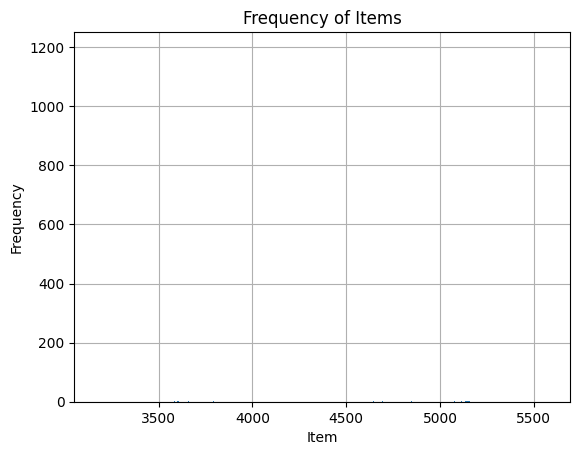

In [22]:
# Flatten the array of arrays into a single list
flat_data = [item for sublist in predictions for item in sublist]

# Count the frequency of each item
unique_items, frequencies = np.unique(flat_data, return_counts=True)

print(unique_items)
print(frequencies)

# Create the frequency plot
plt.bar(unique_items, frequencies)
plt.xlabel('Item')
plt.ylabel('Frequency')
plt.title('Frequency of Items')
plt.grid(True)  # Add grid lines
plt.show()

# IGNORAR

A partir daqui, tem apenas código auxiliar para ajudar a obter uma versão reduzida dos dados. Por isso, irá ficar tudo em comentário.





In [ ]:
'''

# (Prices preços) Reduzir os dados para apenas de uma loja

df_prices = pd.read_csv('sell_prices.csv')

csv_path = "df_prices_Loja1.csv"
id_loja = "CA_1"
coluna = "store_id"

# Ler o arquivo CSV existente, se houver
try:
    df_existing = pd.read_csv(csv_path)
except FileNotFoundError:
    df_existing = pd.DataFrame()

index = 0
still_searching = True

while still_searching:
    actual_price = df_prices.iloc[index]
    loja = actual_price[coluna]
    if loja == id_loja:
        print(index, end=' ')
        # Adicionar a linha ao dataframe existente
        df_existing = pd.concat([df_existing, actual_price], ignore_index=True)
        index = index + 1
        continue
    still_searching = False

# Salvar o dataframe resultante no arquivo CSV, adicionando ao final do arquivo
df_existing.to_csv(csv_path, mode='a', index=False, header=not any(df_existing))

'''